In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import netCDF4
from functions import *

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras

# Przygotowanie danych:

From netCDF4 to tabular:

In [157]:
# create training set (1994 - 2001, one gridpoint):
def create_trainset(to_csv=False):
    data = pd.DataFrame()
    years = range(1994, 2002)
    for year in years:
        filename = 'workdir/data_raw/ERA5_area/data_area_'+str(year)+'.nc'
        f = netCDF4.Dataset(filename)
        var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd']
        # latitudes = f.variables['latitude'][:]
        # longitudes = f.variables['longitude'][:]
        times = netCDF4.num2date(f.variables['time'][:], f.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
        times = [t.isoformat() for t in times]

        variables = {key: f.variables[key][:,4,4] for key in var_names}
        df = pd.DataFrame({**{
            'Date Time': times,
            **variables
        }})
        df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)
        df['tp'] = df['tp'].fillna(0)
        ssrd_new = df['ssrd']
        ssrd_new = ssrd_new.where(ssrd_new>10, 0) / 3600 / 1000 #unit from [J/m^2] to [kW/m^2]
        df['ssrd'] = ssrd_new
        df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
        df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
        df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

        data = data.append(df)

    if to_csv:
        data.to_csv('data/data_spacial/trainset_[50,20].csv', index = False)

    f.close()
    return data

train = create_trainset(to_csv=True)

In [158]:
# Creating testsets (year 2002, all gridpoint):
def create_datasets(filename, to_csv=False):
    f = netCDF4.Dataset(filename)
    var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd']
    latitudes = f.variables['latitude'][:]
    longitudes = f.variables['longitude'][:]
    times = netCDF4.num2date(f.variables['time'][:], f.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    times = [t.isoformat() for t in times]
    dataframes = []
    for i in range(len(latitudes)):
        row = []
        for j in range(len(longitudes)):
            variables = {key: f.variables[key][:,i,j] for key in var_names}
            df = pd.DataFrame({**{
                'Date Time': times,
                **variables
            }})
            df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)
            df['tp'] = df['tp'].fillna(0)
            ssrd_new = df['ssrd']
            ssrd_new = ssrd_new.where(ssrd_new>10, 0) / 3600 / 1000 #unit from [J/m^2] to [kW/m^2]
            df['ssrd'] = ssrd_new
            df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
            df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
            df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)
            row.append(df)
            if to_csv:
                df.to_csv('data/data_spacial/data_[{},{}].csv'.format(latitudes[i],longitudes[j]), index = False)
        dataframes.append(row)
    f.close()
    return dataframes

test_sets = create_datasets('workdir/data_raw/ERA5_area/data_area_2002.nc', to_csv=True)


In [159]:
test_sets[4][4].head()

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,266.380440,264.058589,102678.363977,0.000076,0.0,2002-01-01 00:00:00,6.263798,9.871162
1,266.168470,263.678457,102777.784631,0.000039,0.0,2002-01-01 01:00:00,6.185724,9.817204
2,265.287029,262.801167,102832.547484,0.000024,0.0,2002-01-01 02:00:00,6.041196,9.536901
3,265.521079,263.113755,102840.533733,0.000035,0.0,2002-01-01 03:00:00,5.805256,9.601193
4,265.930004,263.685525,102868.404113,0.000048,0.0,2002-01-01 04:00:00,5.926083,9.747236


In [160]:
train

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,276.591677,273.597511,100506.631227,1.948620e-06,0.0,1994-01-01 00:00:00,2.114012,5.362126
1,276.239812,273.369413,100396.295800,4.871549e-07,0.0,1994-01-01 01:00:00,2.405844,5.321953
2,276.160179,273.007498,100208.275227,8.673617e-19,0.0,1994-01-01 02:00:00,2.965654,6.456440
3,276.464820,273.139795,100168.467620,8.673617e-19,0.0,1994-01-01 03:00:00,2.014695,4.494271
4,276.756498,273.067564,100306.869420,1.428988e-05,0.0,1994-01-01 04:00:00,2.988498,6.387397
...,...,...,...,...,...,...,...,...
8755,268.717000,266.967436,102182.766620,3.642980e-04,0.0,2001-12-31 19:00:00,4.235353,7.019902
8756,268.546893,266.427170,102303.229532,2.378932e-04,0.0,2001-12-31 20:00:00,4.918296,7.977007
8757,268.176911,266.142592,102400.924228,2.040622e-04,0.0,2001-12-31 21:00:00,5.307329,8.410772
8758,267.034643,264.759426,102492.450642,1.640802e-04,0.0,2001-12-31 22:00:00,5.672169,9.402993


## Zamiana daty na sygnał

In [161]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

Text(0.5, 1.0, 'Time of day signal')

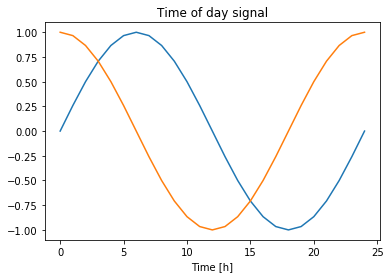

In [162]:
train = datetimeToSignal(train)
for i in range(len(test_sets)):
    for j in range(len(test_sets[i])):
        test_sets[i][j] = datetimeToSignal(test_sets[i][j])

plt.plot(np.array(train['Day sin'])[:25])
plt.plot(np.array(train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## Normalizacja

In [163]:
values_train = train.values
values_test = []
for i in range(len(test_sets)):
    buffer = []
    for j in range(len(test_sets[i])):
        buffer.append(test_sets[i][j].values)
    values_test.append(buffer)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values_train)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

values_train = scaler.transform(values_train)
for i in range(len(test_sets)):
    for j in range(len(test_sets[i])):
        values_test[i][j] = scaler.transform(values_test[i][j])

## Zmiana szeregu czasowego na input/output

In [164]:
# Multiple steps predicted:

# # convert history into inputs and outputs
# def to_supervised(data, n_input, n_out=1):
#     X, y = list(), list()
#     in_start = 0
#     # step over the entire history one time step at a time
#     for _ in range(len(data)):
#         # define the end of the input sequence
#         in_end = in_start + n_input
#         out_end = in_end + n_out
#         # ensure we have enough data for this instance
#         if out_end < len(data):
#             X.append(data[in_start:in_end, :])
#             y.append(data[in_end:out_end, 0])
#         # move along one time step
#         in_start += 1
#     return array(X), array(y)

# One step predicted:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

X_train, y_train = to_supervised(values_train, n_input=24, n_out=6)
Xs_test = []
ys_test = []
for i in range(len(test_sets)):
    Xs_buffer, ys_buffer = [], []
    for j in range(len(test_sets[i])):
        X_test, y_test = to_supervised(values_test[i][j], n_input=24, n_out=6)
        Xs_buffer.append(X_test)
        ys_buffer.append(y_test)
    Xs_test.append(Xs_buffer)
    ys_test.append(ys_buffer)

In [165]:
print(X_train.shape)
print(y_train.shape)
print(Xs_test[0][0].shape)
print(ys_test[0][0].shape)

(70098, 24, 11)
(70098, 1)
(8730, 24, 11)
(8730, 1)


# Stworzenie i trening modeli

In [166]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, display = True):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$windspeed_{10}[m/s]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])

    return testScore

def cross_corr(model, X_test, y_test):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")


## Dense:

In [167]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dense(units=24, activation='relu'),
    Dense(units=24, activation='relu'),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
dense.summary()
compile_and_fit(dense, X_train, y_train)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 24, 24)            288       
_________________________________________________________________
dense_6 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_7 (Dense)              (None, 24, 24)            600       
_________________________________________________________________
dense_8 (Dense)              (None, 24, 1)             25        
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 24)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              25        
_________________________________________________________________
reshape_3 (Reshape)          (None, 1)                

Test Score: 1.0486 RMSE


1.048604600136635

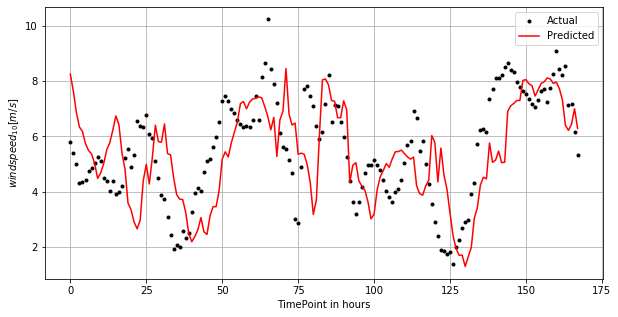

In [168]:
evaluate(dense, Xs_test[4][4], ys_test[4][4])

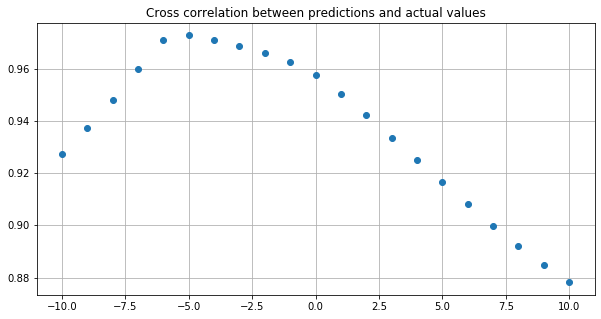

In [169]:
cross_corr(dense, Xs_test[4][4], ys_test[4][4])

## Predykcje dla różnych punktów siatki

In [175]:
rmses = np.zeros([9,9])
for i in range(rmses.shape[0]):
    for j in range(rmses.shape[1]):
        rmses[i,j] = evaluate(dense, Xs_test[i][j], ys_test[i][j], display=False)

In [176]:
rmses

array([[1.15034376, 1.15503717, 1.13694248, 1.12089462, 1.12726394,
        1.10502278, 1.09781845, 1.07513359, 1.04918426],
       [1.1655055 , 1.16588376, 1.14303185, 1.11492512, 1.1162714 ,
        1.10232258, 1.11601259, 1.1174051 , 1.08109768],
       [1.15980992, 1.17223854, 1.17967091, 1.15220186, 1.16591735,
        1.12618702, 1.13437173, 1.10017999, 1.04797038],
       [1.13668966, 1.1524512 , 1.14750851, 1.13750349, 1.15895632,
        1.11177289, 1.09345532, 1.07059237, 1.03387608],
       [1.08284984, 1.04984028, 1.04505326, 1.03700675, 1.0486046 ,
        1.01087132, 1.00011927, 1.00284647, 1.00519509],
       [0.95864103, 0.90793446, 0.90516575, 0.90721769, 0.9117948 ,
        0.88492861, 0.89454884, 0.94074882, 0.98347188],
       [0.89879309, 0.85407164, 0.84082245, 0.82100381, 0.81222161,
        0.81339891, 0.82936074, 0.90605839, 0.95890682],
       [0.83800197, 0.80253947, 0.77199633, 0.76589741, 0.76600375,
        0.7674057 , 0.82296043, 0.88021578, 0.92518992],


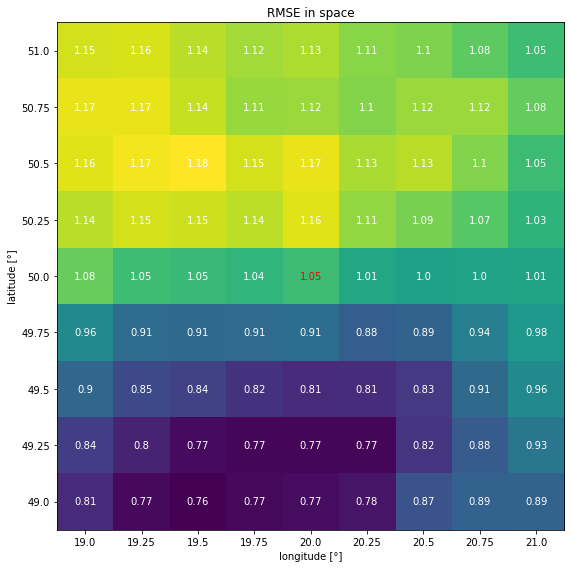

In [234]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.imshow(rmses)
ax.set_xticklabels(np.arange(18.75, 21.25,0.25))
ax.set_yticklabels(np.flip(np.arange(49, 51.5,0.25,)))
ax.set_xlabel("longitude [°]")
ax.set_ylabel("latitude [°]")
ax.set_title("RMSE in space")

for i in range(len(rmses)):
    for j in range(len(rmses[i])):
        if (i,j) == (4,4):
            text = plt.text(j, i, round(rmses[i, j],2),
                            ha="center", va="center", color="r")
        else:
            text = plt.text(j, i, round(rmses[i, j],2),
                            ha="center", va="center", color="w")

fig.tight_layout()